In [1]:
import numpy as np
import sklearn as sk
import os

In [2]:
feature_dir = "output/features_resnet18/"
thumbs_dir = "output/torch_thumbs"
meta_file="./output/torch_thumbs.meta"
#n_files = 100
n_files=-1
files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir)[:n_files]]
print(len(files))


16459


In [3]:
data_pairs = [(f, np.load(f)) for f in files]

In [4]:
import umap

from sklearn.preprocessing import StandardScaler

#scaled_data = StandardScaler().fit_transform()

stacked_data = np.stack([a for _,a in data_pairs], axis=0)
scaled_data = StandardScaler().fit_transform(stacked_data)
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)
embedding.shape



(16459, 2)

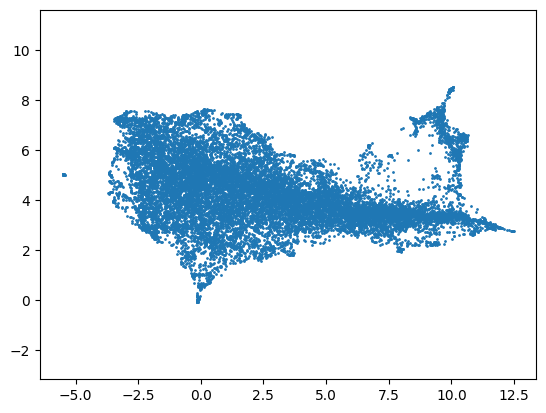

In [5]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    )
plt.gca().set_aspect('equal', 'datalim')



In [6]:
from typing import Callable
def meta_getter(meta_filename: str) -> Callable:
    hashes = {}
    with open(meta_filename) as h:
        for line in h:
            orig_hash, orig = [s.strip() for s in line.split('\t', 1)]
            hashes.setdefault(orig_hash, []).append(orig)
    def getter(path: str) -> dict:
        hash_ = os.path.basename(path).split('.', 1)[0]
        return {
            "orig": ", ".join(hashes.get(hash_, []))
        }
    return getter

meta_getter(meta_file)(data_pairs[0][0])

{'orig': '/Volumes/Public/usb_backup/backup-2021-11-09.22.07.40.163/03.Foto/foto/2014 06 POL Maja 2 miesiace/2014 06 POL 9-10 tydz Mai/20140606_190855.jpg'}

In [9]:
import base64
import io
from PIL import Image
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
import pandas as pd

def load_embeddable_image(embedding_path: str, images_dir: str) -> str:
    # From https://umap-learn.readthedocs.io/en/latest/basic_usage.html
    image_basename = os.path.basename(embedding_path).rstrip('.npy')
    image_path = os.path.join(images_dir, image_basename)
    image = Image.open(image_path).convert('RGB')
    buffer = io.BytesIO()
    image.save(buffer, format='png')
    return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_embeddable_image_path(embedding_path: str, images_dir: str) -> str:
    """Requires simple http server running
     python3 -m http.server
    """
    image_basename = os.path.basename(embedding_path).rstrip('.npy')
    image_path = os.path.join(images_dir, image_basename)
    return f"http://localhost:8000/{image_path}"
    
print("output")
output_notebook()
df = pd.DataFrame(embedding, columns=('x', 'y'))
#df['image'] = [load_embeddable_image(p, "output/torch_thumbs") for p, _ in data_pairs]
df['image_path'] = [get_embeddable_image_path(p, thumbs_dir) for p, _ in data_pairs]
meta = meta_getter(meta_file)
# df['orig'] = [meta(p)['orig'] for p, _ in data_pairs] # uncomment to show original path from meta file
datasource = ColumnDataSource(df)
print("datasource")

plot_figure = figure(
    #title='UMAP projection of the Digits dataset',
    width=1000,
    height=800,
    tools=('pan, wheel_zoom, reset')
)

# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# plot_figure.add_tools(HoverTool(tooltips="""
# <div>
#     <div>
#         <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
#     </div>
# </div>
# """))
plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image_path' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <!-- 
    <div>
        <span style='font-size: 10px'>@orig</span>
    </div>
    -->
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    #color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)


output


Loading BokehJS ...

datasource
